In [ ]:
import torch
from kemsekov_torch.train import load_checkpoint
from kemsekov_torch.train import load_last_checkpoint

# you can load your trained model from checkpoint
# vqvae2_path = 'runs/vqvae2-16-4x'
# trained_vqvae = torch.jit.load(vqvae2_path+"/model.pt")
# trained_vqvae = load_last_checkpoint(trained_vqvae,vqvae2_path,-1).eval().cpu()

# ot load pretrained
trained_vqvae = torch.jit.load("vqvae.pt")

ind shapes [torch.Size([1, 64, 64]), torch.Size([1, 32, 32]), torch.Size([1, 16, 16])]


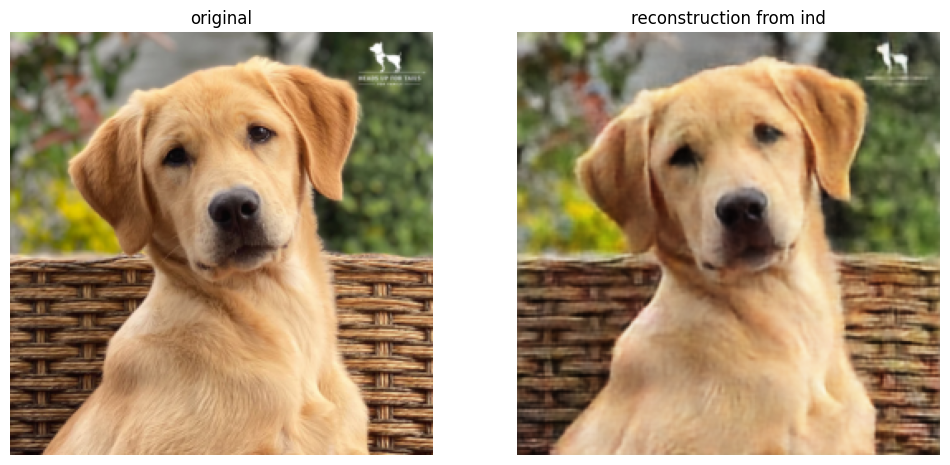

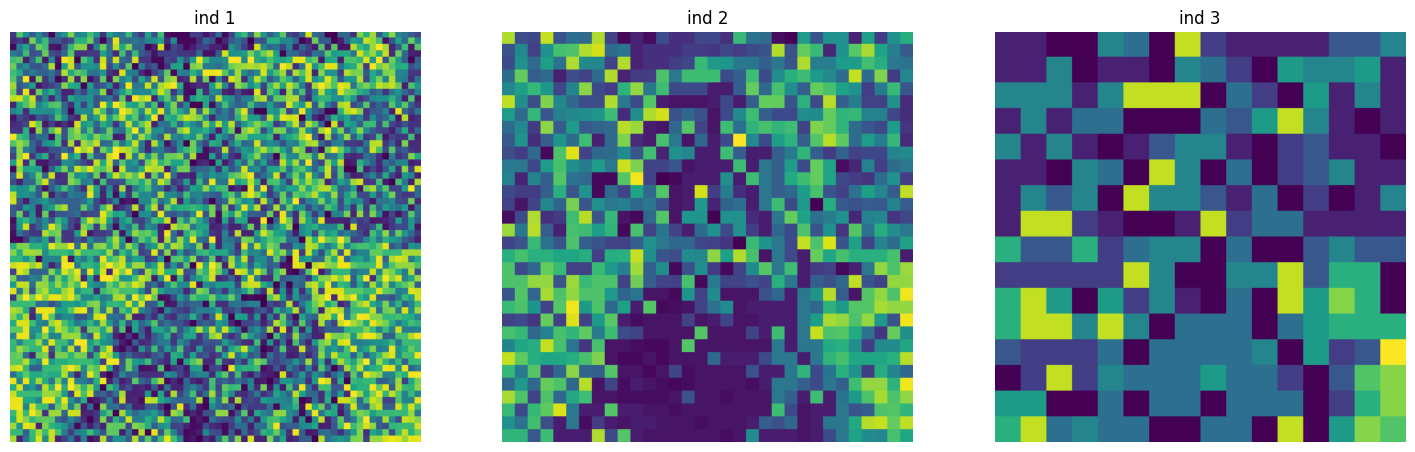

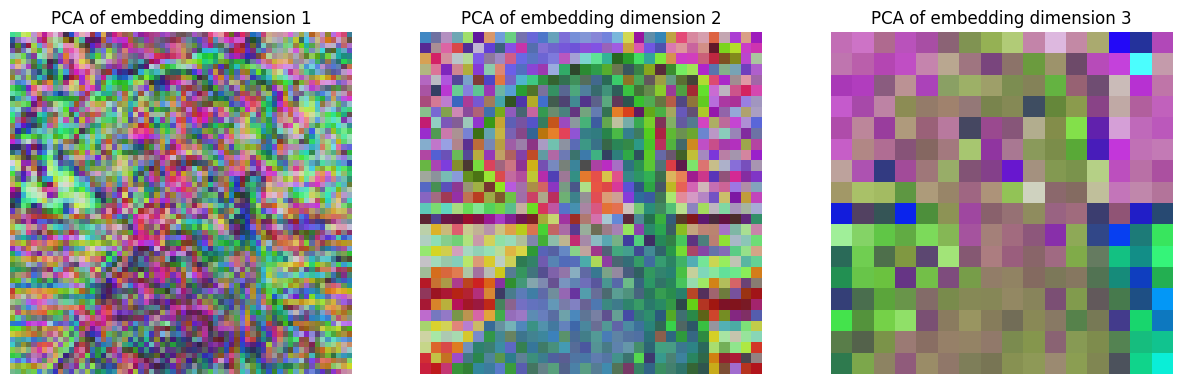

In [44]:
import random
import os
import PIL.Image
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import torchvision.transforms as T

images = ['eval_images/'+f for f in os.listdir("eval_images")]
sample = random.sample(images,k=1)[0]
sample = PIL.Image.open(sample)
sample = T.Compose([
    T.Resize(256),
    T.RandomCrop((256,256)),
    T.ToTensor()
])(sample).unsqueeze(0)


with torch.no_grad():
    z, all_z_emb, all_zd_emb, ind = trained_vqvae.encode(sample)
    rec_ind = trained_vqvae.decode_from_ind(ind)
    rec_ind=rec_ind.sigmoid()

print("ind shapes",[v.shape for v in ind])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(T.ToPILImage()(sample[0]).resize((256,256)))
plt.title("original")
plt.axis('off')


plt.subplot(1,2,2)
plt.imshow(T.ToPILImage()(rec_ind[0]).resize((256,256)))
plt.title("reconstruction from ind")
plt.axis('off')
plt.show()

plt.figure(figsize=(18,6))
i = 1
for ind_ in ind:
    plt.subplot(1,3,i)
    plt.imshow(T.ToPILImage()(ind_/512).resize((256,256),0))
    plt.title(f"ind {i}")
    plt.axis('off')
    i+=1

# render model embeddings from 3 levels via PCA
i = 1
plt.figure(figsize=(15,5))
for z_ in all_z_emb:
    emb = PCA(n_components=3,whiten=True).fit_transform(z_[0].flatten(1).T).T
    emb = torch.Tensor(emb).view(3,*z_.shape[2:])
    emb=(emb).sigmoid()
    
    plt.subplot(1,len(all_z_emb),i)
    plt.title(f"PCA of embedding dimension {i}")
    plt.axis('off')
    plt.imshow(T.ToPILImage()(emb))
    i+=1